<a href="https://www.kaggle.com/code/redpolish/a-b-testing-are-players-coming-back-or-no?scriptVersionId=110369642" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="section-one"></a>
# The Dataset

### Context
This dataset includes A/B test results of Cookie Cats to examine what happens when the first gate in the game was moved from level 30 to level 40. When a player installed the game, they were randomly assigned to either gate30 or gate40.

### Content
The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:
* userid: A unique number that identifies each player.
* version: Whether the player was put in the control group (gate30 - a gate at level 30) or the group with the moved gate (gate40 - a gate at level 40).
* sumgamerounds: the number of game rounds played by the player during the first 14 days after install.
* retention1: Did the player come back and play 1 day after installing?
* retention_7: Did the player come back and play 7 days after installing?

<a id="section-two"></a>
# Problem

As players progress through the levels of the game, they will occasionally encounter gates that force them to wait a non-trivial amount of time or make an in-app purchase to progress. In addition to driving in-app purchases, these gates serve the important purpose of giving players an enforced break from playing the game, hopefully resulting in that the player's enjoyment of the game being increased and prolonged.

But where should the gates be placed? Initially the first gate was placed at level 30, but in this notebook we're going to analyze an AB-test where we moved the first gate in Cookie Cats from level 30 to level 40. In particular, we will look at the impact on player retention. 

<a id="section-three"></a>
# EDA

We're gonna look into the dataset to see if there's any difference between the control (gate_30) and test (gate_40) group.

In [1]:
#importing libraries to make viz and count stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [2]:
data = pd.read_csv('../input/mobile-games-ab-testing-cookie-cats/cookie_cats.csv')
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
data.shape

(90189, 5)

We have 5 columns and 90189 rows.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [5]:
data.duplicated().sum()

0

Looks like we have no nulls and duplicates! 

*happy cheers bc no clean up codes required*

Now on to the visualizations we go.

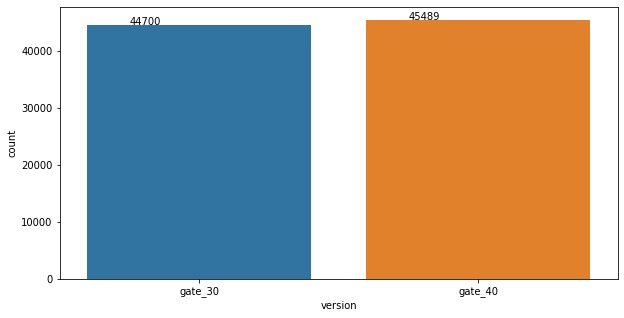

In [6]:
plt.figure(figsize = (10, 5))
ax = sns.countplot(x = 'version', data = data)
for p in ax.patches:
   ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+0.02))

There's no big difference in players number between the control and test group.

In [7]:
data['sum_gamerounds'].describe()

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

The average players play about 51 rounds during the 14 days after install. Now let's see if we have any outliers.

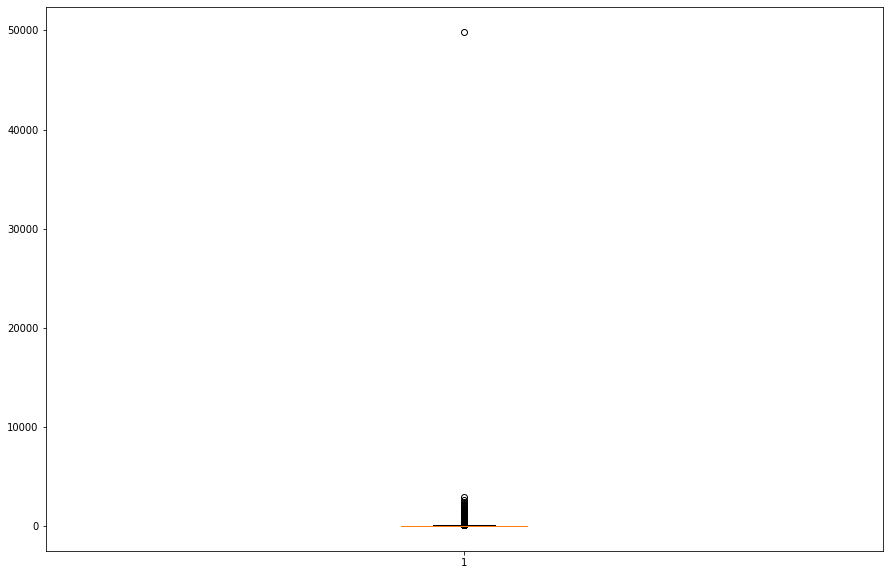

In [8]:
fig=plt.figure(figsize=(15,10))
plt.boxplot(data['sum_gamerounds'])
plt.show()

We have lots of outliers. These outliers are skewing the data, but they can be handled by removing or replacing the them. For now, I'm gonna keep these outliers because I want to see test result for the overall players.

In [9]:
#a bonus
data[data.sum_gamerounds==49854]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


I see the max value of the sum_gamerounds is 49854. This step is actually a because I wanna see the userid. Honestyly, I'm both impressed and concerned about this user. What kind of person spend their time playing this cat game, why are they so dedicated, the developer should give this person an award or something.

Anyway, back to the code.

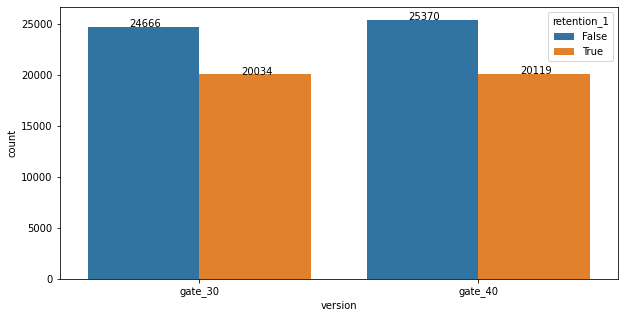

In [10]:
plt.figure(figsize = (10, 5))
ax = sns.countplot(x = 'version', data = data, hue = 'retention_1')
for p in ax.patches:
   ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+0.02))

##### The control group (gate_30)
20034 players came back to the game after **1 day**, and there's 24666 players who don't.

##### The test group (gate_40)
20119 players came back to the game after **1 day**, and there's 25370 players who don't.

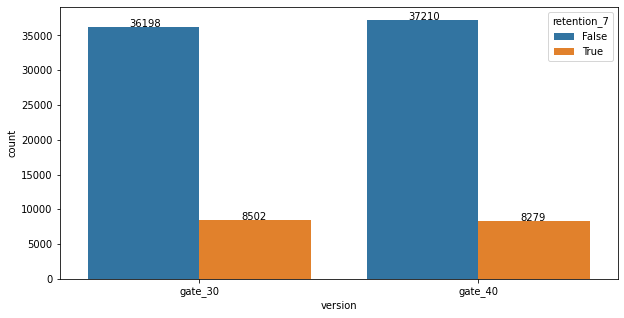

In [11]:
plt.figure(figsize = (10, 5))
ax = sns.countplot(x = 'version', data = data, hue = 'retention_7')
for p in ax.patches:
   ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.15, p.get_height()+0.02))

##### The control group (gate_30)
8502 players came back to the game after **7 days**, and there's 36198 players who don't.

##### The test group (gate_40)
8279 players came back to the game after **7 day**, and there's 37210 players who don't

It seems there's **no** big differences between the two groups after **1 day** of installing. 

But there's a **significant differences** in the number of players who come back between the two groups after **7 days** of installing.

Now we shall see by hypothesis testing whether putting the gate on level 40 rather than level 30 is impacting the players' retention. 

<a id="section-four"></a>
# Hypothesis Testing

The million dollar question in this test is: **Is there any difference in the amount of players' retention between putting the gate on level 30 or level 40?**

Our basic assumption is there's **no difference** between both groups. Let's set that as our null hypothesis and the negation as our alternative hypothesis.

**H0: There is no difference between the two groups.**
> If p-value >= alpha (0.05); H0 is accepted.

**H1: There is a difference between the two groups.**
> If p-value < alpha (0.05); H0 is rejected.

There's lots of ways to do hypothesis testing. How do we decide which test to use?

Francesco Casalegno explained many tests for A/B Testing in [this](https://towardsdatascience.com/a-b-testing-a-complete-guide-to-statistical-testing-e3f1db140499) article. He made a decision tree that helps us to choose a suitable test for our data.

![](https://miro.medium.com/max/720/1*Vzkwzrs4DOmBBa1LymW-PQ.png)

Now let's start from the top of the tree. Discrete metrics only have two possible values (0 or 1, Yes or No, etc.).
Cookie Cats used this metric to measure the impact of the game gate on the players' retention. There's only True or False values in the retention columns.

I have yet to find literatures that establish how big is the sample size to be considered 'large'. But there's 90189 rows in this data and that, obviously, is a large amount of sample. 

Based on Casalegno's decision tree, we can use Pearson's chi squared test for our A/B Testing.

##### Are the players coming back after 1 day of installing?

We're gonna start by grouping the players whether they came back or no.

In [12]:
#count how many players
day_1 = data.groupby(['version','retention_1']).size()
day_1

version  retention_1
gate_30  False          24666
         True           20034
gate_40  False          25370
         True           20119
dtype: int64

In [13]:
#make a new dataset
new1 = pd.DataFrame(data=[[20034,20119],[24666,25370]],
                  index=["True","False"],
                  columns=["gate_30","gate_40"])
new1

,gate_30,gate_40
True,20034,20119
False,24666,25370


In [14]:
#using chi2 test
chi2_val, p_val = chi2_contingency(new1.values, correction=False)[:2]

alpha=0.05

print("- Pearson's chi-squared test:")
print(f"   - χ2 value: {chi2_val:.3f}")
print(f"   - p-value: {p_val}")

#hypothesis
{'H0 is rejected' if p_val <= alpha else 'H0 is accepted'}

- Pearson's chi-squared test:
   - χ2 value: 3.183
   - p-value: 0.07440965529692188


{'H0 is accepted'}

##### Are the players coming back after 7 days of installing?

In [15]:
#count how many players
day_7 = data.groupby(['version','retention_7']).size()
day_7

version  retention_7
gate_30  False          36198
         True            8502
gate_40  False          37210
         True            8279
dtype: int64

In [16]:
#make a new dataset
new2 = pd.DataFrame(data=[[8502,8279],[36198,37210]],
                  index=["True","False"],
                  columns=["gate_30","gate_40"])
new2

,gate_30,gate_40
True,8502,8279
False,36198,37210


In [17]:
#using chi2 test
chi2_val, p_val = chi2_contingency(new2.values, correction=False)[:2]

alpha=0.05

print("- Pearson's chi-squared test:")
print(f"   - χ2 value: {chi2_val:.3f}")
print(f"   - p-value: {p_val}")

#hypothesis
{'H0 is rejected' if p_val <= alpha else 'H0 is accepted'}

- Pearson's chi-squared test:
   - χ2 value: 10.013
   - p-value: 0.0015542499756142805


{'H0 is rejected'}

There's **no** difference between the players' retention after **1 day** of installing, but there **is** a difference after **7 days** of installing.

<a id="section-five"></a>
# Conclusion

This data contains 90,189 rows players that installed the game while the AB-test was running. There's no duplicates and missing values so no clean ups are required. However, there's outliers in the number of game rounds played by the player during the first 14 days after installing (*shoutout to user #6390605!*). For future projects, we could handle these outliers for cleaner data.

Based from the visualization on EDA, there's **no** big differences between the two groups after **1 day** of installing. But there's a **significant differences** in the number of players who come back between the two groups after **7 days** of installing.

The Chi Squared Test is carried to confirm our assumptions. Players tend to come back during the first 7 days after installing when **the gate is at level 30**. Therefore, **the gate should not be moved**.

#### Future projects recs
Aside from handling the outliers, you could investigate whether the change in gate placement impact the sum of the game rounds. It would be interesting if Cookie Cats also provided data about in-app purchases. We could analyse whether the gate placement impact the purchases, are players with high sum of game rounds willing to do purchase, etc.